In [137]:
import requests
import copy
from music21 import *
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

In [138]:
# Download files - don't use this code to scrape

# for i in range(1,25):
#     file_name = 'Fugue{}.mid'.format(i)
#     url = 'http://www.bachcentral.com/WTCBkI/{}'.format(file_name)
#     r = requests.get(url)

#     with open(file_name, 'wb') as f:
#         f.write(chunk)

# for i in range(1,13):
#     file_name = 'Fugue{}.mid'.format(i)
#     url = 'http://www.bachcentral.com/WTCBkIIx/{}'.format(file_name)
#     r = requests.get(url)
#     file_name = 'Fugue{}_wtcii.mid'.format(i)
#     with open(file_name, 'wb') as f:
#         f.write(chunk)

In [139]:
def clean_zero_durations(midi_data):
    for stream in range(len(midi_data)):
        for element in range(len(midi_data[stream])):
            current_element = midi_data[stream][element]
            if isinstance(current_element, note.Note) or isinstance(current_element, chord.Chord) or isinstance(current_element, note.Rest):
                if current_element.duration.quarterLength == 0:
                    midi_data[stream][element].quarterLength = 0.125
    return midi_data

def print_zero_midi_data(midi_data):
    for stream in range(len(midi)):
        for element in range(len(midi[stream])):
            current_element = midi[stream][element]
            if current_element.duration.quarterLength == 0:
                print(midi[stream][element].quarterLength, current_element)

def print_midi_data(midi_data):
    for stream in range(len(midi_data)):
        current_stream = midi_data[stream].notesAndRests
        for element in range(len(current_stream)):
            current_element = current_stream[element]
            print(current_element.duration.type, current_element, current_element.duration.quarterLength)

In [140]:
def get_notes(midi_data, begin=False, end=False):
    
    if begin:
        features = ['begin']
    else:
        features = []
        
    midi_data = midi_data.chordify()
    for element in midi_data.notesAndRests:
        if isinstance(element, note.Rest):
            features.append('{}%{}'.format(element.duration.quarterLength, element.name))
        elif isinstance(element, note.Note):
            features.append('{}%{}'.format(element.duration.quarterLength, element.namewithOctave))            
        elif isinstance(element, chord.Chord):
            current_chord = [str(element.duration.quarterLength)]
            for chord_note in element:
                if (chord_note.tie) and (chord_note.tie.type == 'start') or not(chord_note.tie):
                    current_chord.append(chord_note.nameWithOctave)
            if len(current_chord) == 1:
                current_chord.append('rest')
            features.append('%'.join(current_chord))
            
### alternative code for chords with ties counted as individual notes ###
#         elif isinstance(element, chord.Chord):
#             current_chord = [str(element.duration.quarterLength)]
#             for pitch in element.pitches:
#                 current_chord.append(pitch.nameWithOctave)
#             features.append('%'.join(current_chord))

            
    if end:
        features.append('end')
        
    return features

In [141]:
def load_data():
    notes_data = []
    cwd = os.getcwd() + '/midi_files'
    print(cwd)
    for path in Path(cwd).glob('**/*.mid'):
        # because path is object not string
        file = str(path)
        try:
            midi = converter.parse(file)
            midi = clean_zero_durations(midi)
            notes = get_notes(midi, False, False)
            notes_data.extend(notes)
        except:
            print(file)
    return notes_data

In [142]:
notes_data = load_data()

/home/ubuntu/midi_files
/home/ubuntu/midi_files/fugue12.mid
/home/ubuntu/midi_files/fugue19.mid
/home/ubuntu/midi_files/fugue6.mid


In [143]:
## https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/
len(notes_data)

21390

In [144]:
df = pd.DataFrame(notes_data)
df.columns = ['notes']
df['count'] = df.groupby('notes')['notes'].transform('count')

Text(0.5,1,'Histogram of number of times a note combination appears')

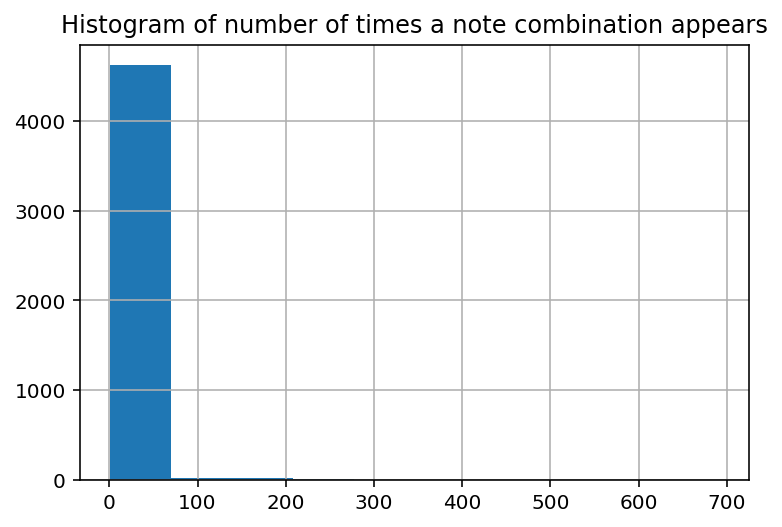

In [145]:
df.drop_duplicates()['count'].hist()
plt.title('Histogram of number of times a note combination appears')

In [146]:
# create mapping of unique chars to integers
chars = sorted(list(set(notes_data)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

In [147]:
n_chars = len(notes_data)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  21390
Total Vocab:  4662


In [157]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 50
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = notes_data[i:i + seq_length]
    seq_out = notes_data[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Patterns:  21340


In [158]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [159]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [160]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [210]:
model.fit(X, y, epochs=50, batch_size=32, callbacks=callbacks_list)

Epoch 1/50
21340/21340 [==============================] - 45s 2ms/step - loss: 1.0979

Epoch 00001: loss did not improve from 0.96974
Epoch 2/50
21088/21340 [============================>.] - ETA: 0s - loss: 1.0188

KeyboardInterrupt: 

In [211]:
# load the network weights
filename = "weights-improvement-27-0.9697.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [212]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [236]:
note_sequence = []

# pick a random seed
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    note_sequence.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
" 0.25%D50.25%A3%C50.25%G3%C60.25%A3%E50.25%D4%F50.25%A40.25%B-40.25%C4%E50.25%D4%F50.25%E4%G50.25%F4%A4%C50.25%E40.25%D4%B-4%F50.25%C4%A4%F50.25%D40.25%B-3%G4%E50.25%A3%C5%F50.25%G3%B-40.25%F3%A40.25%B-3%G40.25%A40.25%F40.25%E4%G50.25%D4%F50.25%C4%E50.25%A3%F#4%D50.25%E-50.25%C50.25%G3%G4%B-40.25%F3%A40.25%E30.25%D3%F4%A40.25%E30.25%C3%D50.25%B2%G40.25%A20.25%G2%D50.25%C3%E4%G40.25%B20.25%C3%E50.25%F3%A40.25%C#50.25%D50.25%E3%G40.25%D3%B40.25%E3%C50.25%A3%F40.25%E50.25%F50.25%G3%B4 "

Done.


In [237]:
note_sequence

['0.25%G5',
 '0.25%B3%D5',
 '0.25%G3%B4',
 '0.25%F3%D5',
 '0.25%F3',
 '0.25%D3%F4',
 '0.25%D3',
 '0.25%C#3%B-4%E5%G5',
 '0.25%C5',
 '0.25%C#4%G#4',
 '0.25%G#4',
 '0.25%D4%A4',
 '0.25%G3%G4',
 '0.25%G2%A4',
 '0.25%C5',
 '0.25%G2%B4',
 '0.25%F3',
 '0.25%G#3%C5',
 '0.25%C5',
 '0.25%D4%F4',
 '0.25%C3',
 '0.25%E-4%C5',
 '0.25%G4',
 '0.25%E3%G4',
 '0.25%A4',
 '0.25%G#3%F4',
 '0.25%A2%C5',
 '0.25%G4',
 '0.25%F4',
 '0.25%G4',
 '0.25%B-3%D5',
 '0.25%C#5',
 '0.25%D3%B-3%F5',
 '0.25%C5',
 '0.25%F3%B-3%G#5',
 '0.25%C4',
 '0.25%B3',
 '0.25%E-4',
 '0.25%C#4%E5',
 '0.25%C4%E-5',
 '0.25%E5',
 '0.25%E3%G5',
 '0.25%E-4%G4',
 '0.25%E3%C#5',
 '0.25%G3%E4',
 '0.25%A3',
 '0.25%A3%F#4',
 '0.25%C3',
 '0.25%G#3',
 '0.25%F2%G#4',
 '0.25%E3',
 '0.25%F#3',
 '0.25%C#5',
 '0.25%D3%F4',
 '0.25%B3%F#4%E-5',
 '0.25%B2%G4',
 '0.25%B3',
 '0.25%B3',
 '0.25%F#5',
 '0.25%B2',
 '0.25%B2',
 '0.25%D5',
 '0.25%A3',
 '0.25%F#5',
 '0.25%A3%F#4',
 '0.25%E4',
 '0.25%F3%A4',
 '0.25%D4',
 '0.25%G#3%E4',
 '0.25%A3',
 '0.25%G#3%E4',
 

In [238]:
def from_string_to_music(note_sequence):
    midi_stream = stream.Stream()
    for entry in note_sequence:
        if entry == 'begin' or entry == 'end':
            continue

        current_notes = entry.split('%')
        duration = float(eval(current_notes[0]))

        if current_notes[1] == 'rest':
            midi_stream.append(note.Rest(quarterLength=duration))
        else:
            chord_notes = []
            for entry in current_notes[1:]:
                chord_notes.append(note.Note(quarterLength=duration, nameWithOctave=entry))
            midi_stream.append(chord.Chord(chord_notes))

    midi_stream.write('midi', fp='test_output_no_ties.mid')
    return midi_stream

In [239]:
midi_stream = from_string_to_music(note_sequence)

for entry in midi_stream.notesAndRests:
    print(entry)

<music21.chord.Chord G5>
<music21.chord.Chord B3 D5>
<music21.chord.Chord G3 B4>
<music21.chord.Chord F3 D5>
<music21.chord.Chord F3>
<music21.chord.Chord D3 F4>
<music21.chord.Chord D3>
<music21.chord.Chord C#3 B-4 E5 G5>
<music21.chord.Chord C5>
<music21.chord.Chord C#4 G#4>
<music21.chord.Chord G#4>
<music21.chord.Chord D4 A4>
<music21.chord.Chord G3 G4>
<music21.chord.Chord G2 A4>
<music21.chord.Chord C5>
<music21.chord.Chord G2 B4>
<music21.chord.Chord F3>
<music21.chord.Chord G#3 C5>
<music21.chord.Chord C5>
<music21.chord.Chord D4 F4>
<music21.chord.Chord C3>
<music21.chord.Chord E-4 C5>
<music21.chord.Chord G4>
<music21.chord.Chord E3 G4>
<music21.chord.Chord A4>
<music21.chord.Chord G#3 F4>
<music21.chord.Chord A2 C5>
<music21.chord.Chord G4>
<music21.chord.Chord F4>
<music21.chord.Chord G4>
<music21.chord.Chord B-3 D5>
<music21.chord.Chord C#5>
<music21.chord.Chord D3 B-3 F5>
<music21.chord.Chord C5>
<music21.chord.Chord F3 B-3 G#5>
<music21.chord.Chord C4>
<music21.chord.Cho